# Exploratory Data Analysis
### 02/17/2020
### Group 6: Lukas Hering, Tommy Luangrath, Ian Luck, Andrea Simenstad

# Overview

<img src="used-car.jpg">

In this project, we are presented with some data and a business problem. Our goal is to provide a solution to our business problem while using the spark framework.


#### The Dataset

The dataset that we are provided with is the "Used Cars Database" scraped from Ebay Kleinanzeigen in Germany. The dataset contains a collection of over 370,000 used cars with a list of fields. The fields for our dataset include dateCrawled, name of the care, sellect, model of the car, kilometers the car has driven etc.

#### Business Problem


Our business problem is to predict how much a used car should be valued at, given relavent information such as the name of the car, the type of seller, offer type, how many kilometers the car has driven, etc. 

#### Main Objective

The main objective for this project, is to build an efficient and effective model that is able to predict the sale price of a used vehicle. With our model, we will able to provide eBay or other car dealerships an efficient algorithm to predict the price a used car should be sold at in order to maximize the profit and to minimize time spent evaluating the price of a vehicle.

To achieve our main objective, we will be creating multiple types of regression models including Linear regression (lasso and ridge), decision trees, random forests and gradient boosted forests.

### Data Profiling

#### Dataset Field Definitions
We are working with a dataset about used cars, which is partially in German. The dataset is hosted on Kaggle at https://www.kaggle.com/orgesleka/used-cars-database.

Where indicates by ‘\*’, the table uses verbatim the dataset field descriptions from https://www.kaggle.com/orgesleka/used-cars-database.

| key                | type          |  description   |
| -------------      | ------------- | -------------  |
| dateCrawled        | timestamp     | \*when this ad was first crawled, all field-values are taken from this date |
| name               | string        | \*"name" of the car|
| seller             | string        | \*private or dealer |
| offerType          | string        |                     |
| price              | integer       | \*the price on the ad to sell the car |
| abtest             | string        |                     |
| vehicleType        | string        |                     |
| yearOfRegistration | integer       | \*at which year the car was first registered |
| gearbox            | string        |                     | 
| powerPS            | integer       | \*power of the car in PS | 
| model               | string        |                           | 
| kilometers          | integer       | \*how many kilometers the car has driven | 
| monthOfRegistration | integer       | \*at which month the car was first registered |
| fuelType            | string        |                  |
| brand               | string        |                  |
| notRepairedDamage   | string        | \*if the car has a damage which is not repaired yet |
| dateCreated         | timestamp     | \*the date for which the ad at ebay was created |
| nrOfPictures        | integer       | \*number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless (bug in crawler!) ) |
| postalCode          | integer       |                   |
| lastSeenOnline      | timestamp     | \*when the crawler saw this ad last online |




#### Data Quality
The nrOfPictures field can be dropped due to data quality issues (see notes from Kaggle website).
- The field notRepairedDamage is likely to be dropped. Currently, the field contains the values null, ja, and nein. It is not clear if null represents that the user skipped the field or if there has never been any damage to the car.
    - nein has 263390 entries
    - null has 72123 entries
    - ja has 36310 entries

#### Distributions and Dependencies
- There are outliers for the price field.

#### Feature engineering
- How balanced is our dataset?
    - The price field definitely has outliers, including 0 and 2147483647.

- Data Normalization
    - Date fields can be normalized. For example, the difference between dateCreated and lastSeenOnline.
    - The string values for the fields gearBox and fuelType can be transformed from strings to a corresponding binary.

#### Feature Selection
Currently selected features:
- price
- yearOfRegistration
- Difference between dateCreated and lastSeenOnline
- gearBox (as a standardized integer)
- fuelType (as a standardized integer)
- kilometers


# Exploratory Data Analysis

In [264]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col

spark = SparkSession.builder.master("local[*]").appName("Learning_Spark").getOrCreate()

First, we're going to load our data in our csv file into a spark dataframe in order to used our data with Spark.

In [265]:
data = spark.read.csv('autos.csv',inferSchema=True, header=True)

Now, we'll look at the shape of our dataframe to how many features and how much data we have.

In [266]:
print("Number of entries: " + str(data.count()))
print("Number of features: " + str(len(data.columns)))

Number of entries: 371824
Number of features: 20


Now we can print a few portions of our dataset to get an indication of what our data contains.

In [267]:
data.show(3)

+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|        dateCrawled|                name|seller|offerType|price|abtest|vehicleType|yearOfRegistration|  gearbox|powerPS|model|kilometer|monthOfRegistration|fuelType|     brand|notRepairedDamage|        dateCreated|nrOfPictures|postalCode|           lastSeen|
+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|2016-03-24 11:52:17|          Golf_3_1.6|privat|  Angebot|  480|  test|       null|              1993|  manuell|      0| golf|   150000|                  0|  benzin|volkswagen|             null|2016-03-24 00:00:00|     

## Data Profiling

Now, we will perform some data profiling to get a better understanding of what types of fields our data contains and what quality of data we are dealing with.

In [268]:
data.printSchema()

root
 |-- dateCrawled: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- offerType: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- abtest: string (nullable = true)
 |-- vehicleType: string (nullable = true)
 |-- yearOfRegistration: integer (nullable = true)
 |-- gearbox: string (nullable = true)
 |-- powerPS: integer (nullable = true)
 |-- model: string (nullable = true)
 |-- kilometer: integer (nullable = true)
 |-- monthOfRegistration: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- notRepairedDamage: string (nullable = true)
 |-- dateCreated: timestamp (nullable = true)
 |-- nrOfPictures: integer (nullable = true)
 |-- postalCode: integer (nullable = true)
 |-- lastSeen: timestamp (nullable = true)



In [269]:
data.select("name","dateCreated","lastSeen","price").show(15, truncate=False)

+-----------------------------------------------------------------+-------------------+-------------------+-----+
|name                                                             |dateCreated        |lastSeen           |price|
+-----------------------------------------------------------------+-------------------+-------------------+-----+
|Golf_3_1.6                                                       |2016-03-24 00:00:00|2016-04-07 03:16:57|480  |
|A5_Sportback_2.7_Tdi                                             |2016-03-24 00:00:00|2016-04-07 01:46:50|18300|
|Jeep_Grand_Cherokee_"Overland"                                   |2016-03-14 00:00:00|2016-04-05 12:47:46|9800 |
|GOLF_4_1_4__3T�RER                                               |2016-03-17 00:00:00|2016-03-17 17:40:17|1500 |
|Skoda_Fabia_1.4_TDI_PD_Classic                                   |2016-03-31 00:00:00|2016-04-06 10:17:21|3600 |
|BMW_316i___e36_Limousine___Bastlerfahrzeug__Export               |2016-04-04 00:00:00|2

In [270]:
data.describe(["price","kilometer"]).show()

+-------+------------------+------------------+
|summary|             price|         kilometer|
+-------+------------------+------------------+
|  count|            371823|            371823|
|   mean|17286.338865535483|125618.56044408226|
| stddev|3586530.1840677853|40111.620164944536|
|    min|                 0|              5000|
|    max|        2147483647|            150000|
+-------+------------------+------------------+



In [271]:
data.describe(["offerType"]).show()

+-------+---------+
|summary|offerType|
+-------+---------+
|  count|   371823|
|   mean|     null|
| stddev|     null|
|    min|  Angebot|
|    max|   Gesuch|
+-------+---------+



In [272]:
group_by_gearbox = data.groupby('gearbox')
group_by_brand = data.groupby('brand')
group_by_notRepairedDamage = data.groupby('notRepairedDamage')

In [273]:
group_by_gearbox.agg({'price': 'avg'}).show()

+---------+------------------+
|  gearbox|        avg(price)|
+---------+------------------+
|     null|43990.346585570886|
|automatik|15145.544156332206|
|  manuell|15920.486752589904|
+---------+------------------+



In [274]:
group_by_brand.agg({'price': 'avg'}).show()

+-------------+------------------+
|        brand|        avg(price)|
+-------------+------------------+
|       jaguar|14228.083735909822|
|     daihatsu|1691.6815365551424|
|   mitsubishi|3274.6647078028077|
|         null|              null|
|         lada|3037.4444444444443|
|       toyota| 5235.104468085106|
|         seat| 4356.156703672075|
|         saab| 3808.686090225564|
|   land_rover|16698.858625162127|
|      peugeot| 3168.667391698387|
|     chrysler| 3912.255158184319|
|      citroen| 8875.202082529888|
|         audi| 15863.35696264097|
|mercedes_benz|17244.502687715725|
|          bmw|14838.656460137465|
|         jeep|11998.898514851486|
|       lancia| 3165.754132231405|
|        skoda| 6413.099698955198|
|        rover| 1508.022448979592|
|      hyundai| 5417.859139490271|
+-------------+------------------+
only showing top 20 rows



In [275]:
group_by_brand.agg({'price': 'count'}).show()

+-------------+------------+
|        brand|count(price)|
+-------------+------------+
|       jaguar|         621|
|     daihatsu|         807|
|   mitsubishi|        3063|
|         null|           0|
|         lada|         225|
|       toyota|        4700|
|         seat|        7026|
|         saab|         532|
|   land_rover|         771|
|      peugeot|       11034|
|     chrysler|        1454|
|      citroen|        5186|
|         audi|       32897|
|mercedes_benz|       35346|
|          bmw|       40301|
|         jeep|         808|
|       lancia|         484|
|        skoda|        5647|
|        rover|         490|
|      hyundai|        3649|
+-------------+------------+
only showing top 20 rows



In [276]:
group_by_notRepairedDamage.agg({'price': 'avg'}).show()

+-----------------+-----------------+
|notRepairedDamage|       avg(price)|
+-----------------+-----------------+
|             nein|9128.952507688218|
|             null| 22760.0665252416|
|               ja|65586.87130267144|
+-----------------+-----------------+



In [277]:
for col in data.columns:
    print(col, "number of null: \n", data.filter(data[col].isNull()).count())

dateCrawled number of null: 
 0
name number of null: 
 0
seller number of null: 
 1
offerType number of null: 
 1
price number of null: 
 1
abtest number of null: 
 1
vehicleType number of null: 
 37900
yearOfRegistration number of null: 
 1
gearbox number of null: 
 20224
powerPS number of null: 
 1
model number of null: 
 20499
kilometer number of null: 
 1
monthOfRegistration number of null: 
 1
fuelType number of null: 
 33416
brand number of null: 
 1
notRepairedDamage number of null: 
 72124
dateCreated number of null: 
 1
nrOfPictures number of null: 
 1
postalCode number of null: 
 1
lastSeen number of null: 
 1


As we can see, we have quite a few null values. Now we will have to drop these null values. 

In [278]:
#Remove nulls
data = data.na.drop()

#Drop Unnecessary fields
drop_fields = ['seller', 'offerType', 'notRepairedDamage ', 'dateCrawled', 'name', 'abtest']

#Drop nulls
data = data.drop(*drop_fields)
data = data.filter(data["gearbox"] != 'null')

#Keep data in a specific range
data = data.filter(data["yearOfRegistration"] > 1944)
data = data.filter(data["yearOfRegistration"] < 2018)
data = data.filter(data["powerPS"] > 99)
data = data.filter(data["powerPS"] < 501)
data = data.filter(data["price"] > 99)
data = data.filter(data["price"] < 400000)

for col in data.columns:
    print(col, "number of null: \n", data.filter(data[col].isNull()).count())

price number of null: 
 0
vehicleType number of null: 
 0
yearOfRegistration number of null: 
 0
gearbox number of null: 
 0
powerPS number of null: 
 0
model number of null: 
 0
kilometer number of null: 
 0
monthOfRegistration number of null: 
 0
fuelType number of null: 
 0
brand number of null: 
 0
notRepairedDamage number of null: 
 0
dateCreated number of null: 
 0
nrOfPictures number of null: 
 0
postalCode number of null: 
 0
lastSeen number of null: 
 0


## Feature Engineering

Now that we have a better understanding of our dataset, we now need to transform the features in our dataset into more meaningful features in order for our model to perform optimally.

Now, we need to convert some of our categorical variables into numeric ones. 

In [279]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer

data.groupBy('gearbox').count().show()

indexer = StringIndexer(inputCol="gearbox", outputCol="gearbox_num")
data = indexer.fit(data).transform(data)

data.select("gearbox_num","gearbox").show(5, truncate=False)

+---------+------+
|  gearbox| count|
+---------+------+
|automatik| 51855|
|  manuell|116915|
+---------+------+

+-----------+-------+
|gearbox_num|gearbox|
+-----------+-------+
|0.0        |manuell|
|0.0        |manuell|
|0.0        |manuell|
|0.0        |manuell|
|0.0        |manuell|
+-----------+-------+
only showing top 5 rows



In [280]:
data.groupBy('vehicleType').count().show()

indexer = StringIndexer(inputCol="vehicleType", outputCol="vehicleType_num")
data = indexer.fit(data).transform(data)

data.select("vehicleType_num","vehicleType").show(5, truncate=False)

+-----------+-----+
|vehicleType|count|
+-----------+-----+
|      coupe|12663|
|        bus|19061|
| kleinwagen| 6905|
|     andere|  824|
|  limousine|58391|
|     cabrio|14699|
|        suv|10761|
|      kombi|45466|
+-----------+-----+

+---------------+-----------+
|vehicleType_num|vehicleType|
+---------------+-----------+
|0.0            |limousine  |
|3.0            |cabrio     |
|0.0            |limousine  |
|1.0            |kombi      |
|5.0            |suv        |
+---------------+-----------+
only showing top 5 rows



In [281]:
data.groupBy('model').count().show()

indexer = StringIndexer(inputCol="model", outputCol="model_num")
data = indexer.fit(data).transform(data)

data.select("model","model_num").show(5, truncate=False)

+--------+-----+
|   model|count|
+--------+-----+
|   viano|  358|
| 1_reihe|   45|
|     1er| 3308|
|rx_reihe|  118|
|sportage|  252|
|  x_type|  121|
|  antara|   75|
|     7er|  821|
| boxster|  362|
|      cc|  155|
| clubman|  163|
|  megane| 1415|
|s_klasse|  697|
|    yeti|  188|
|   kalos|    1|
| x_trail|  175|
|   lodgy|   19|
|     200|   11|
|   delta|   22|
| m_reihe|  244|
+--------+-----+
only showing top 20 rows

+-------+---------+
|model  |model_num|
+-------+---------+
|3er    |0.0      |
|2_reihe|20.0     |
|3_reihe|21.0     |
|passat |4.0      |
|navara |160.0    |
+-------+---------+
only showing top 5 rows



In [282]:
data.groupBy('fuelType').count().show()

indexer = StringIndexer(inputCol="fuelType", outputCol="fuelType_num")
data = indexer.fit(data).transform(data)

data.select("fuelType","fuelType_num").show(5, truncate=False)

+--------+-----+
|fuelType|count|
+--------+-----+
|  benzin|92978|
| elektro|   14|
|  andere|   23|
|  diesel|72328|
|     cng|  226|
|  hybrid|   80|
|     lpg| 3121|
+--------+-----+

+--------+------------+
|fuelType|fuelType_num|
+--------+------------+
|benzin  |0.0         |
|benzin  |0.0         |
|benzin  |0.0         |
|diesel  |1.0         |
|diesel  |1.0         |
+--------+------------+
only showing top 5 rows



In [283]:
data.groupBy('brand').count().show()

indexer = StringIndexer(inputCol="brand", outputCol="brand_num")
data = indexer.fit(data).transform(data)

data.select("brand","brand_num").show(5, truncate=False)

+-------------+-----+
|        brand|count|
+-------------+-----+
|       jaguar|  451|
|     daihatsu|   44|
|   mitsubishi| 1176|
|         lada|    2|
|       toyota| 1830|
|         seat| 2375|
|         saab|  399|
|   land_rover|  572|
|      peugeot| 4046|
|     chrysler|  931|
|      citroen| 1552|
|         audi|22685|
|mercedes_benz|22978|
|          bmw|28945|
|       lancia|  128|
|         jeep|  571|
|        skoda| 2663|
|        rover|  182|
|      hyundai| 1530|
|         ford| 9371|
+-------------+-----+
only showing top 20 rows

+----------+---------+
|brand     |brand_num|
+----------+---------+
|bmw       |1.0      |
|peugeot   |7.0      |
|mazda     |8.0      |
|volkswagen|0.0      |
|nissan    |15.0     |
+----------+---------+
only showing top 5 rows



### Engineering New Features

Now that our data is formatted in a more presentable way, lets try to engineer some new features that will aim to capture the problem we are trying to solve, that is predicting the price of a vehicle. 

The first, feature we can think of adding is how often is the car driven. That is how many kilometers per year. We can create a new feature "kilo_per_year" to capture this value directly. 

In [284]:
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType, IntegerType, FloatType

def kilo_per_year(start_year, total_kilo):
    return (total_kilo) / (2017.5 - start_year)

kilo_year_udf = udf(lambda x, y: kilo_per_year(x,y), FloatType())

data = data.withColumn('kilo_per_year', kilo_year_udf('yearOfRegistration', 'kilometer'))

data.select("yearOfRegistration", "kilometer", "kilo_per_year").show(15, truncate=False)

+------------------+---------+-------------+
|yearOfRegistration|kilometer|kilo_per_year|
+------------------+---------+-------------+
|1995              |150000   |6666.6665    |
|2004              |150000   |11111.111    |
|2004              |150000   |11111.111    |
|2005              |150000   |12000.0      |
|2011              |70000    |10769.23     |
|2007              |150000   |14285.714    |
|2004              |150000   |11111.111    |
|2009              |100000   |11764.706    |
|2002              |150000   |9677.419     |
|1990              |150000   |5454.5454    |
|2002              |150000   |9677.419     |
|1995              |150000   |6666.6665    |
|2007              |20000    |1904.762     |
|2004              |150000   |11111.111    |
|2002              |150000   |9677.419     |
+------------------+---------+-------------+
only showing top 15 rows



Furthermore, we note that we have two "timestamp" variables, "lastSeen" and "dateCreated". Using this information, we can infer how long it took the vehicle to sell by taking this difference. Thus, we will create a new variable, "days_to_sell".

In [285]:
import datetime
import time
import pyspark.sql.functions as fn

data = data.withColumn('lastSeen_sec', fn.unix_timestamp(fn.col('lastSeen'), format='yyyy-MM-dd HH:mm:ss.000'))
data = data.withColumn('dateCreated_sec', fn.unix_timestamp(fn.col('dateCreated'), format='yyyy-MM-dd HH:mm:ss.000'))

timediffudf = udf(lambda x, y: (x - y) / (86400), FloatType())

data = data.withColumn('days_to_sell', timediffudf('lastSeen_sec', 'dateCreated_sec'))

data.select("days_to_sell", "lastSeen", "dateCreated").show(15, truncate=False)

+------------+-------------------+-------------------+
|days_to_sell|lastSeen           |dateCreated        |
+------------+-------------------+-------------------+
|2.8035533   |2016-04-06 19:17:07|2016-04-04 00:00:00|
|4.7629514   |2016-04-05 18:18:39|2016-04-01 00:00:00|
|11.44831    |2016-04-06 10:45:34|2016-03-26 00:00:00|
|0.43422455  |2016-04-07 10:25:17|2016-04-07 00:00:00|
|16.323402   |2016-04-06 07:45:42|2016-03-21 00:00:00|
|13.781377   |2016-04-05 18:45:11|2016-03-23 00:00:00|
|4.948669    |2016-04-05 22:46:05|2016-04-01 00:00:00|
|4.698484    |2016-04-05 16:45:49|2016-04-01 00:00:00|
|11.280856   |2016-04-07 06:44:26|2016-03-27 00:00:00|
|0.82001156  |2016-03-13 20:40:49|2016-03-13 00:00:00|
|0.90565974  |2016-03-18 21:44:09|2016-03-18 00:00:00|
|2.636169    |2016-04-05 15:16:05|2016-04-03 00:00:00|
|13.19816    |2016-04-07 04:45:21|2016-03-25 00:00:00|
|13.657061   |2016-03-30 15:46:10|2016-03-17 00:00:00|
|4.532986    |2016-04-05 12:47:30|2016-04-01 00:00:00|
+---------

Next, we note that we have an attribute called postal code. We note that a field like postal code in itself will not be very useful for a regression model as there will be potentially thousands of postal codes to interpret. We can extract a more meaningful significance of a postal code by taking its first digit and mapping it to one of the 10 regions below. 

<img src="German_postcode_information.png">

In [286]:
import math

def get_region(postal_code):
    return int(math.floor(postal_code / 10000))

region_udf = udf(lambda x: get_region(x), IntegerType())

data = data.withColumn('region', region_udf('postalCode'))

data.select("region","postalCode").show(15, truncate=False)

+------+----------+
|region|postalCode|
+------+----------+
|3     |33775     |
|6     |67112     |
|9     |96224     |
|5     |57290     |
|0     |4177      |
|8     |88361     |
|4     |49565     |
|7     |75365     |
|6     |68309     |
|3     |35390     |
|7     |73765     |
|5     |53879     |
|3     |39179     |
|6     |67071     |
|1     |10551     |
+------+----------+
only showing top 15 rows



Now we can drop all of the fields that we no longer need now that we have transformed our original features.

In [287]:
drop_fields = ['vehicleType', 'model', 'gearbox', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen', 'dateCreated_sec', 'lastSeen_sec']
data = data.drop(*drop_fields)

In [288]:
for col in data.columns: #Cast all fields to double
  data = data.withColumn(
    col,
    fn.col(col).cast("double")
  )

In [289]:
data.printSchema()

root
 |-- price: double (nullable = true)
 |-- yearOfRegistration: double (nullable = true)
 |-- powerPS: double (nullable = true)
 |-- kilometer: double (nullable = true)
 |-- gearbox_num: double (nullable = false)
 |-- vehicleType_num: double (nullable = false)
 |-- model_num: double (nullable = false)
 |-- fuelType_num: double (nullable = false)
 |-- brand_num: double (nullable = false)
 |-- kilo_per_year: double (nullable = true)
 |-- days_to_sell: double (nullable = true)
 |-- region: double (nullable = true)



## Feature Elimination

Now, we want to see if any of our variables are highly correlated. If we see any high correlations between variables, we may want to remove them. 

In [290]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data.columns, outputCol=vector_col)
data_vector = assembler.transform(data).select(vector_col)

matrix = Correlation.corr(data_vector, vector_col)

['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'gearbox_num', 'vehicleType_num', 'model_num', 'fuelType_num', 'brand_num', 'kilo_per_year', 'days_to_sell', 'region']


(12.0, 0.0)

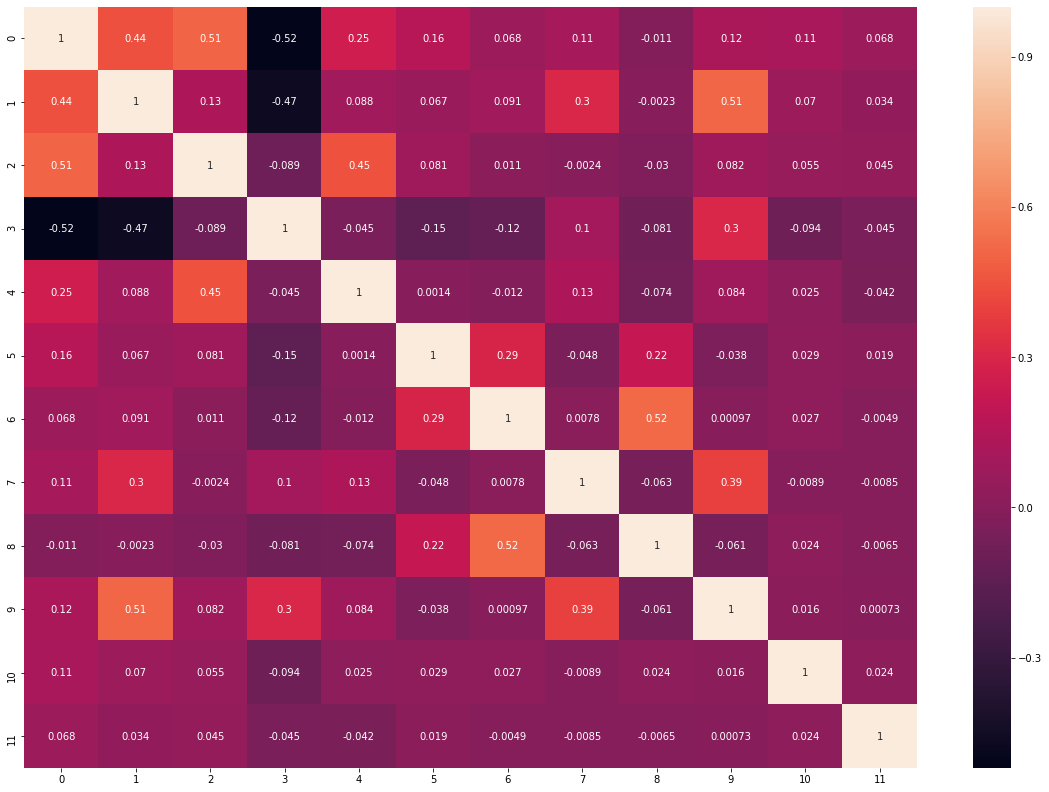

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns

print(data.columns)

# get correlation matrix
corrmatrix = matrix.collect()[0][0].toArray().tolist()

plt.figure(figsize = (20,14))
ax = sns.heatmap(corrmatrix, annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Looking at the plot, we see anything unexpected. We notice that 'yearOfRegistration' and 'kilometer' have a correlation coefficient of -0.47 which is expected for cars with higher kilometer values will very likely have a smaller year of registration. Similarily, we see that 'yearOfRegistration' and 'kilo_per_year' are correlated with a coefficient of 0.52 which also makes sense as newer cars will likely be driven more when they are newer. Regardless of these correlations, the highest magnitude of correlation that was see is 0.52, which seems to indicate that we do not need to remove features because of high correlation with other features.

In [292]:
data.columns

['price',
 'yearOfRegistration',
 'powerPS',
 'kilometer',
 'gearbox_num',
 'vehicleType_num',
 'model_num',
 'fuelType_num',
 'brand_num',
 'kilo_per_year',
 'days_to_sell',
 'region']

### Scaling Data

Before moving forward, we want to make sure our data is scaled so certain values do not disproportionately, effect the trained model.

In [293]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

featurecols =  ['yearOfRegistration','powerPS','kilometer','gearbox_num','vehicleType_num','model_num','fuelType_num','brand_num','kilo_per_year','days_to_sell','region']

#Create a new dataframe with one field with entries as 10-dimensional vectors
assembler = VectorAssembler(inputCols = featurecols, outputCol="features")
feature_df = assembler.transform(data).select("price", "features")

feature_df.show()

+-------+--------------------+
|  price|            features|
+-------+--------------------+
|  650.0|[1995.0,102.0,150...|
| 2200.0|[2004.0,109.0,150...|
| 2000.0|[2004.0,105.0,150...|
| 2799.0|[2005.0,140.0,150...|
|17999.0|[2011.0,190.0,700...|
| 7550.0|[2007.0,136.0,150...|
| 1850.0|[2004.0,102.0,150...|
|10400.0|[2009.0,160.0,100...|
| 3699.0|[2002.0,231.0,150...|
|  500.0|[1990.0,118.0,150...|
| 2500.0|[2002.0,193.0,150...|
| 3300.0|[1995.0,113.0,150...|
|18000.0|[2007.0,218.0,200...|
| 3500.0|[2004.0,122.0,150...|
|11900.0|[2002.0,129.0,150...|
| 7999.0|[2007.0,177.0,150...|
| 2100.0|[1998.0,193.0,150...|
|13500.0|[2012.0,109.0,150...|
|39600.0|[2014.0,306.0,300...|
| 1000.0|[1998.0,101.0,150...|
+-------+--------------------+
only showing top 20 rows



In [315]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaled_model = scaler.fit(feature_df)

scaled_df = scaled_model.transform(feature_df)

scaled_df.show()

scaled_df = scaled_df.drop("features")

scaled_df.show()

+-------+--------------------+--------------------+
|  price|            features|     scaled_features|
+-------+--------------------+--------------------+
|  650.0|[1995.0,102.0,150...|[-1.5500504836151...|
| 2200.0|[2004.0,109.0,150...|[-0.0492634554826...|
| 2000.0|[2004.0,105.0,150...|[-0.0492634554826...|
| 2799.0|[2005.0,140.0,150...|[0.11749065875432...|
|17999.0|[2011.0,190.0,700...|[1.11801534417599...|
| 7550.0|[2007.0,136.0,150...|[0.45099888722821...|
| 1850.0|[2004.0,102.0,150...|[-0.0492634554826...|
|10400.0|[2009.0,160.0,100...|[0.78450711570210...|
| 3699.0|[2002.0,231.0,150...|[-0.3827716839565...|
|  500.0|[1990.0,118.0,150...|[-2.3838210547998...|
| 2500.0|[2002.0,193.0,150...|[-0.3827716839565...|
| 3300.0|[1995.0,113.0,150...|[-1.5500504836151...|
|18000.0|[2007.0,218.0,200...|[0.45099888722821...|
| 3500.0|[2004.0,122.0,150...|[-0.0492634554826...|
|11900.0|[2002.0,129.0,150...|[-0.3827716839565...|
| 7999.0|[2007.0,177.0,150...|[0.45099888722821...|
| 2100.0|[19

### Principal Component Analysis

Principal Component Analysis or PCA for short, is a very common preprocessing technique in machine learning that involves transforming vectors in our original feature space into a new space where the resulting principal components are very loosely correlated to one another. PCA is especially helpful in regression models, as it helps model stability and allows us to remove variables by simply dropping some of the least significant principal components.

In [295]:
from pyspark.ml.feature import PCA

pca = PCA(k=9, inputCol="scaled_features", outputCol="pca")
model = pca.fit(scaled_df)
transformed = model.transform(scaled_df)

transformed = transformed.drop("scaled_features")

transformed.show()

+-------+--------------------+
|  price|                 pca|
+-------+--------------------+
|  650.0|[2.62707868996715...|
| 2200.0|[0.87106136456174...|
| 2000.0|[0.96630958999674...|
| 2799.0|[0.09188278165921...|
|17999.0|[-2.1467141160112...|
| 7550.0|[-0.8065875627644...|
| 1850.0|[1.01842591653508...|
|10400.0|[-0.4236445550294...|
| 3699.0|[0.08500390586343...|
|  500.0|[3.16608513771704...|
| 2500.0|[-0.3754250246966...|
| 3300.0|[1.12817631685678...|
|18000.0|[-0.1537913265376...|
| 3500.0|[-0.4070264584900...|
|11900.0|[0.30101836885465...|
| 7999.0|[-0.5334192911179...|
| 2100.0|[0.89726809658979...|
|13500.0|[-2.8844583920190...|
|39600.0|[-2.2262414592830...|
| 1000.0|[2.19136137883557...|
+-------+--------------------+
only showing top 20 rows



# Models

Before we begin training our models, we will have to partition our dataset into a training and test set. Here we decide to allocate 80% of our data to training and 20% to testing.

In [296]:
train_data, test_data = transformed.withColumnRenamed("price", "target").withColumnRenamed("pca", "features") \
.randomSplit([.8,.2],seed=4710)

print('Train Data Count: {0}\n'.format(train_data.count()))
train_data.show()
print('Test Data Count: {0}\n'.format(test_data.count()))
test_data.show()

Train Data Count: 134736

+------+--------------------+
|target|            features|
+------+--------------------+
| 100.0|[1.63092085315663...|
| 100.0|[2.44419003223697...|
| 100.0|[2.69696226539372...|
| 110.0|[2.17445799759187...|
| 120.0|[2.30879944287450...|
| 130.0|[0.83461432213545...|
| 150.0|[-0.8656550179542...|
| 150.0|[-0.7640460344654...|
| 150.0|[0.60529124170460...|
| 150.0|[2.02375287364225...|
| 150.0|[2.10866931538885...|
| 160.0|[1.76682915176105...|
| 180.0|[1.43391847450836...|
| 180.0|[2.29032869805678...|
| 199.0|[2.43366968056460...|
| 200.0|[-3.2089949006277...|
| 200.0|[1.26162272039454...|
| 200.0|[1.48907252160777...|
| 200.0|[1.65129134338912...|
| 200.0|[1.91449985935197...|
+------+--------------------+
only showing top 20 rows

Test Data Count: 34034

+------+--------------------+
|target|            features|
+------+--------------------+
| 150.0|[0.85467945974567...|
| 150.0|[1.76070422309028...|
| 150.0|[2.01570740180268...|
| 180.0|[2.2741808049440

Good, now we are ready to train our base models for our ensemble model.

### Linear Regression

Our first model that we are creating is a linear regression model. We added a regularization parameter of 0.3 to add a regularization term to the loss function in order to minimize overfitting. The elastic net term was added to combine lasso and ridge regression methods to reduce the effect that correlated variables will have like creating degeneracies and wild behavior.

In [331]:
linearModel.explainParams()

'aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0, current: 0.8)\nepsilon: The shape parameter to control the amount of robustness. Must be > 1.0. (default: 1.35)\nfeaturesCol: features column name (default: features)\nfitIntercept: whether to fit an intercept term (default: True)\nlabelCol: label column name (default: label, current: target)\nloss: The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError) (default: squaredError)\nmaxIter: maximum number of iterations (>= 0) (default: 100, current: 25)\npredictionCol: prediction column name (default: prediction, current: lr_predict)\nregParam: regularization parameter (>= 0) (default: 0.0, current: 0.3)\nsolver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (Default auto) (default:

In [297]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="target", predictionCol="lr_predict", maxIter=25, regParam=0.3, elasticNetParam=0.8)

linearModel = lr.fit(train_data)

In [298]:
from pyspark.sql.functions import rand

lrpredictions = linearModel.transform(test_data)

lrpredictions.select("lr_predict", "target").orderBy(rand(4710)).limit(5).show()

+-------------------+-------+
|         lr_predict| target|
+-------------------+-------+
|  9485.164252277307|12500.0|
| 10576.062342528909| 1300.0|
|  8362.764505354635| 7300.0|
|  3526.621872447662| 2300.0|
|-1234.9415124694406| 3199.0|
+-------------------+-------+



In [299]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="target", predictionCol="lr_predict", metricName="rmse")
rmse = evaluator.evaluate(lrpredictions)
print("RMSE: {0}\n".format(rmse))

RMSE: 6238.9729174849235



### Decision Tree

Judging from the description below, we determined that the default parameters for this model would be the best option for our circumstances.

In [330]:
decisionTreeModel.explainParams()

'cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext (default: 10)\nfeaturesCol: features column name (default: features)\nimpurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)\nlabelCol: label column name (default: label, current: target)\nmaxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)\nmaxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf no

In [300]:
from pyspark.ml.regression import DecisionTreeRegressor

dtr = DecisionTreeRegressor(labelCol="target", predictionCol="dtr_predict")

decisionTreeModel = dtr.fit(train_data)

In [301]:
dtrpredictions = decisionTreeModel.transform(test_data)

dtrpredictions.select("dtr_predict", "target").orderBy(rand(4710)).limit(5).show()

+------------------+-------+
|       dtr_predict| target|
+------------------+-------+
|  8514.66670736174|12500.0|
|  8514.66670736174| 1300.0|
| 5633.675161419347| 7300.0|
|3216.6659935816538| 2300.0|
|3216.6659935816538| 3199.0|
+------------------+-------+



In [302]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="dtr_predict", metricName="rmse")
rmse = evaluator.evaluate(dtrpredictions)
print("RMSE: {0}\n".format(rmse))

RMSE: 6078.129268908162



### Random Forest

Judging from the description below, we determined that the default parameters for this model would be the best option for our circumstances.

In [329]:
randomForestmodel.explainParams()

'cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)\nfeaturesCol: features column name (default: features)\nimpurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)\nlabelCol: label column name (default: label, current: target)\nmaxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number o

In [303]:
from pyspark.ml.regression import RandomForestRegressor

rfr = RandomForestRegressor(labelCol="target", predictionCol="rfr_predict")

randomForestmodel = rfr.fit(train_data)

In [304]:
rfrpredictions = randomForestmodel.transform(test_data)

rfrpredictions.select("rfr_predict", "target").orderBy(rand(4710)).limit(5).show()

+------------------+-------+
|       rfr_predict| target|
+------------------+-------+
| 6506.653264955003|12500.0|
|5994.0930190728695| 1300.0|
| 5754.830028992233| 7300.0|
| 4109.218778325036| 2300.0|
| 3645.728406397918| 3199.0|
+------------------+-------+



In [305]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="rfr_predict", metricName="rmse")
rmse = evaluator.evaluate(rfrpredictions)
print("RMSE: {0}\n".format(rmse))

RMSE: 5759.123173336423



### Gradient-boosted Tree Regression

Judging from the description below, we determined that the default parameters for this model would be the best option for our circumstances.

In [327]:
GBTModel.explainParams()

'cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: all)\nfeaturesCol: features column name (default: features)\nimpurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)\nlabelCol: label column name (default: label, current: target)\nlossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: squa

In [306]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol="target", predictionCol="gbt_predict")

GBTModel = gbt.fit(train_data)

In [307]:
gbtpredictions = GBTModel.transform(test_data)

gbtpredictions.select("gbt_predict", "target").orderBy(rand(4710)).limit(5).show()

+------------------+-------+
|       gbt_predict| target|
+------------------+-------+
|10254.240150454978|12500.0|
|  7604.94017787026| 1300.0|
| 4674.465555656492| 7300.0|
| 3188.398121264135| 2300.0|
|1645.7039943579898| 3199.0|
+------------------+-------+



In [308]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="gbt_predict", metricName="rmse")
rmse = evaluator.evaluate(gbtpredictions)
print("RMSE: {0}\n".format(rmse))

RMSE: 5357.588574008797



It seems like our gradient-boosted tree regression algorithm performed the best, now we will analyze our results in more detail.

# Model Results

Judging just from the RMSE error outputed in the model section, it is clear that the Gradient-boosted tree regressor performed the best out of all of them models, however this metric does give us much information about how the model performed by themselves, it only gives a relative performance measure. A better performance measure for determining how "good" our models performed is an $R^2$ value, which gives us a ratio of how much variance in the dependent variable is explained by our independent variables. Furthermore, we can also use a more familiar metric like the mean absolute error. 

### Linear Regression Results

In [309]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="lr_predict", metricName="rmse")
rmse = evaluator.evaluate(lrpredictions)
print("Root Mean Squared Error: {0}\n".format(rmse))

evaluator = RegressionEvaluator(labelCol="target", predictionCol="lr_predict", metricName="r2")
r2 = evaluator.evaluate(lrpredictions)
print("R^2: {0}\n".format(r2))

evaluator = RegressionEvaluator(labelCol="target", predictionCol="lr_predict", metricName="mae")
mae = evaluator.evaluate(lrpredictions)
print("Mean Absolute Error: {0}\n".format(mae))

Root Mean Squared Error: 6238.9729174849235

R^2: 0.5639361151561464

Mean Absolute Error: 3443.323071692948



### Decision Tree Results

In [310]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="dtr_predict", metricName="rmse")
rmse = evaluator.evaluate(dtrpredictions)
print("Root Mean Squared Error: {0}\n".format(rmse))


evaluator = RegressionEvaluator(labelCol="target", predictionCol="dtr_predict", metricName="r2")
r2 = evaluator.evaluate(dtrpredictions)
print("R^2: {0}\n".format(r2))

evaluator = RegressionEvaluator(labelCol="target", predictionCol="dtr_predict", metricName="mae")
mae = evaluator.evaluate(dtrpredictions)
print("Mean Absolute Error: {0}\n".format(mae))

Root Mean Squared Error: 6078.129268908162

R^2: 0.5861301559143608

Mean Absolute Error: 3302.247085164937



### Random Forest Results

In [311]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="rfr_predict", metricName="rmse")
rmse = evaluator.evaluate(rfrpredictions)
print("Root Mean Squared Error: {0}\n".format(rmse))

evaluator = RegressionEvaluator(labelCol="target", predictionCol="rfr_predict", metricName="r2")
r2 = evaluator.evaluate(rfrpredictions)
print("R^2: {0}\n".format(r2))

evaluator = RegressionEvaluator(labelCol="target", predictionCol="rfr_predict", metricName="mae")
mae = evaluator.evaluate(rfrpredictions)
print("Mean Absolute Error: {0}\n".format(mae))

Root Mean Squared Error: 5759.123173336423

R^2: 0.6284334133157226

Mean Absolute Error: 3286.697102354238



### Gradient-boosted Tree Regression Results

In [312]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="gbt_predict", metricName="rmse")
rmse = evaluator.evaluate(gbtpredictions)
print("Root Mean Squared Error: {0}\n".format(rmse))

evaluator = RegressionEvaluator(labelCol="target", predictionCol="gbt_predict", metricName="r2")
r2 = evaluator.evaluate(gbtpredictions)
print("R^2: {0}\n".format(r2))

evaluator = RegressionEvaluator(labelCol="target", predictionCol="gbt_predict", metricName="mae")
mae = evaluator.evaluate(gbtpredictions)
print("Mean Absolute Error: {0}\n".format(mae))

Root Mean Squared Error: 5357.588574008797

R^2: 0.6784395423052021

Mean Absolute Error: 2757.2862222435433



Good, now that we have a general performance measure. It's quite clear that our gradient-boosted tree regression model performed the best with an $R^2$ value of 0.67 and a mean absolute error of 2757. Thus, we know that this model can explain 70% the variance in car prices just from the independent variables alone. Furthermore, it will have an average price error of around 2700 euros. To get a better idea of what our model does, we can try to fix some variables and see how the predicted price changes. 

### Model Visualization

Now, lets get a better visualization for how our model actually performed. 

In [333]:
gbtpredictions.show()

+------+--------------------+------------------+
|target|            features|       gbt_predict|
+------+--------------------+------------------+
| 150.0|[0.85467945974567...| 4196.603587056485|
| 150.0|[1.76070422309028...| 1662.088026524306|
| 150.0|[2.01570740180268...|1949.7654596729876|
| 180.0|[2.27418080494408...|1461.0291416784414|
| 199.0|[1.38105809185644...|2503.6924539503375|
| 200.0|[0.93783390107879...|1662.8748799760806|
| 200.0|[1.70148701598240...|1594.7215898114398|
| 222.0|[2.13751520078694...|1679.2029634556652|
| 250.0|[1.40400055776668...|1708.5207057894308|
| 250.0|[1.93715738561776...|  6550.53047572773|
| 250.0|[2.36653884268127...|2494.3230413590813|
| 300.0|[0.97551297248946...| 2233.340136101774|
| 300.0|[1.37080066027883...|1394.3911946319427|
| 300.0|[2.45949493895566...| 1805.359435602326|
| 300.0|[2.63102606200640...|1753.0777008235652|
| 300.0|[2.68431398799377...|2422.6669479435404|
| 350.0|[-0.5237233107358...| 21255.51967955572|
| 350.0|[1.408413726

In [360]:
import pandas as pd

pd_df = gbtpredictions.select("target", "gbt_predict").toPandas()
feat_df = gbtpredictions.rdd.map(lambda x:[float(y) for y in x['features']]).toDF(["pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9"]).toPandas()

In [361]:
pd_df = pd.concat([pd_df, feat_df], axis=1, sort=False)

In [362]:
pd_df

,target,gbt_predict,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9
0,150.0,4196.603587,0.854679,0.419656,1.352298,-1.700462,-0.653273,-2.161674,-0.110501,0.255309,0.697186
1,150.0,1662.088027,1.760704,-0.011203,-0.126292,0.085708,-0.066321,-1.779539,-0.059012,-0.189272,0.070408
2,150.0,1949.765460,2.015707,0.433201,0.386100,-0.036659,-0.313522,-1.139146,0.130492,0.068791,-0.262859
3,180.0,1461.029142,2.274181,1.610154,-1.428248,-1.308429,-0.926458,-0.091607,1.950513,-0.716407,-0.691615
4,199.0,2503.692454,1.381058,-0.605524,0.993533,-1.386338,-0.835816,0.558377,0.294487,0.103371,0.934673
...,...,...,...,...,...,...,...,...,...,...,...
34029,46990.0,65200.635314,4.103167,2.149948,0.953706,-1.884080,1.170569,0.603275,-0.272186,1.197510,-1.414982
34030,49500.0,30897.532765,-2.089863,1.416615,2.159011,1.698543,-0.636113,1.805926,0.875956,1.633476,0.220246
34031,49900.0,51104.634818,1.117600,1.639237,0.989745,-2.335795,0.293784,0.458012,-0.703890,-0.817984,-2.183059
34032,56900.0,50178.478880,-3.412396,2.010616,2.755326,0.312585,0.431596,1.582054,-0.571960,0.889549,-0.868740


Now we can visualize how well our model performed by plotting "target" and "gbt_predict" with respect to our principal components.

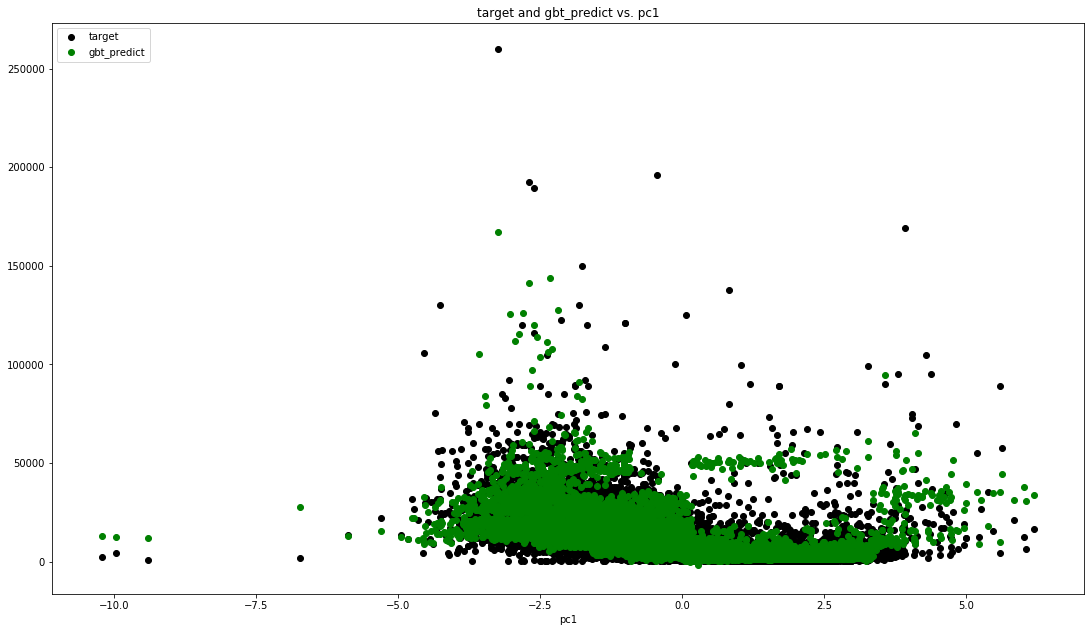

In [377]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.scatter(pd_df["pc1"], pd_df["target"], color="k", label="target")
plt.scatter(pd_df["pc1"], pd_df["gbt_predict"], color="g", label="gbt_predict")
plt.legend(loc="upper left")
plt.title("target and gbt_predict vs. pc1")
plt.xlabel("pc1")
plt.show()

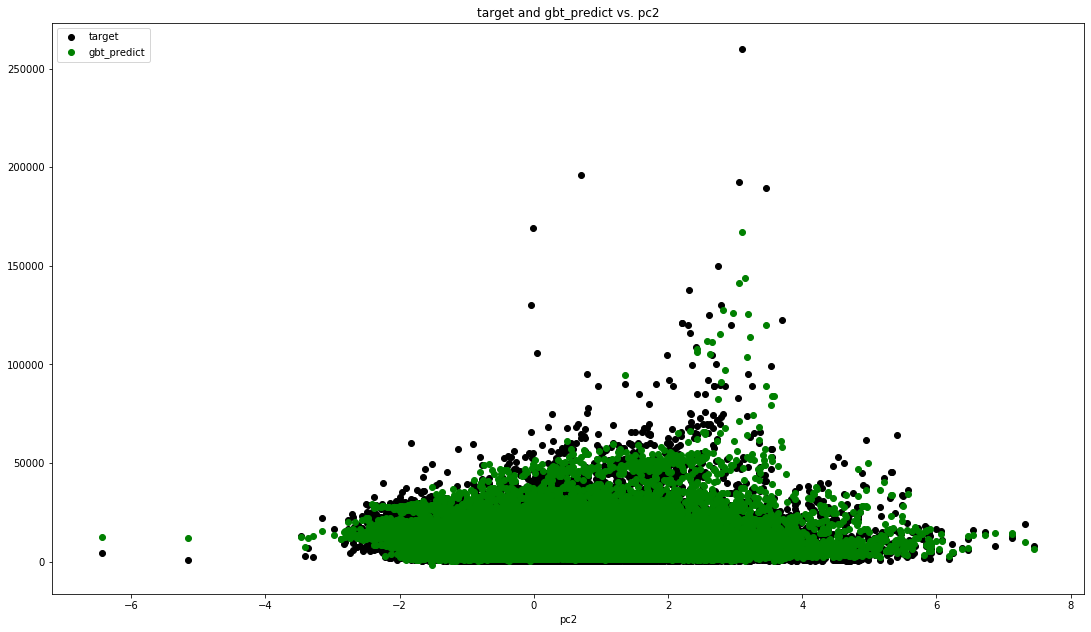

In [380]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.scatter(pd_df["pc2"], pd_df["target"], color="k", label="target")
plt.scatter(pd_df["pc2"], pd_df["gbt_predict"], color="g", label="gbt_predict")
plt.legend(loc="upper left")
plt.title("target and gbt_predict vs. pc2")
plt.xlabel("pc2")
plt.show()

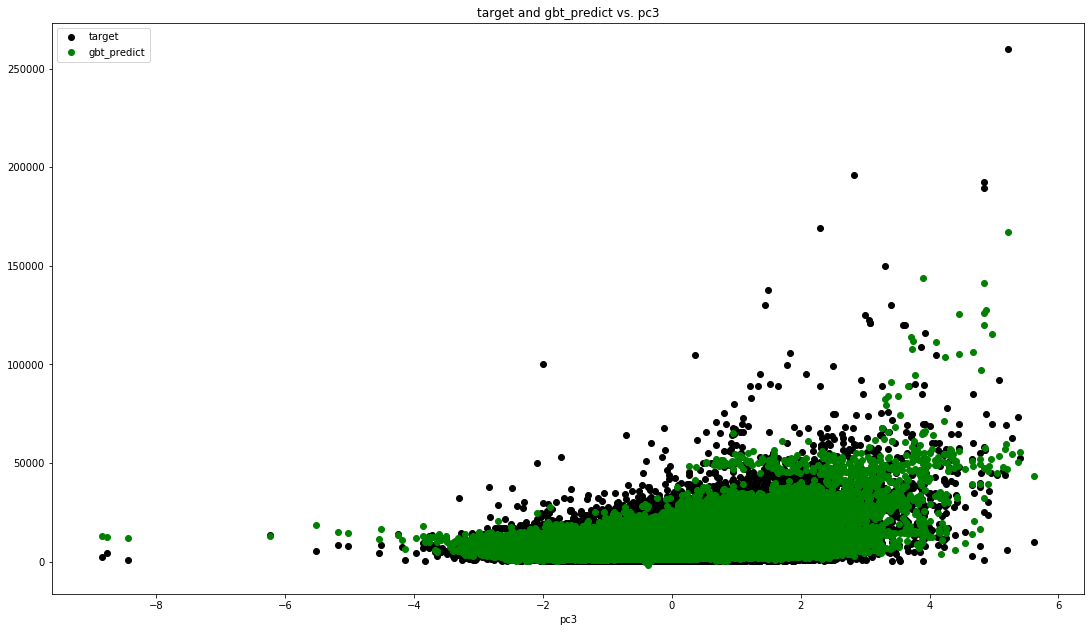

In [381]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.scatter(pd_df["pc3"], pd_df["target"], color="k", label="target")
plt.scatter(pd_df["pc3"], pd_df["gbt_predict"], color="g", label="gbt_predict")
plt.legend(loc="upper left")
plt.title("target and gbt_predict vs. pc3")
plt.xlabel("pc3")
plt.show()

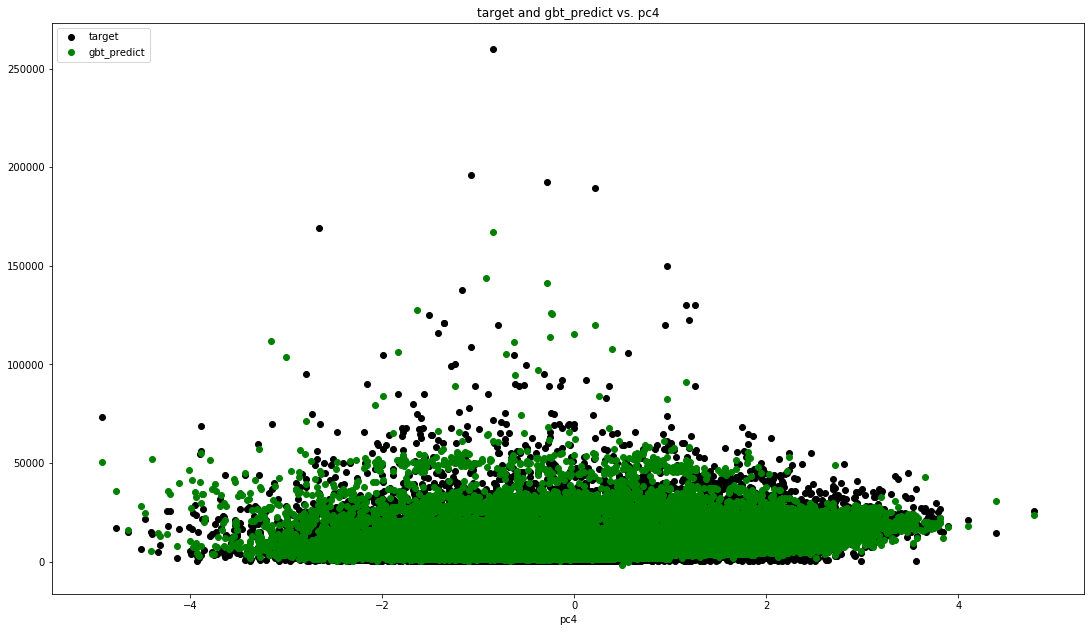

In [382]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.scatter(pd_df["pc4"], pd_df["target"], color="k", label="target")
plt.scatter(pd_df["pc4"], pd_df["gbt_predict"], color="g", label="gbt_predict")
plt.legend(loc="upper left")
plt.title("target and gbt_predict vs. pc4")
plt.xlabel("pc4")
plt.show()

Looking at the graphs above, it is clear that the model does sucessfully capture a lot of the patterns in the data. It is clear that in the majority of cases, the model is able to give a realistic price estimate. Furthermore, with an $R^2$ value of 0.67 and a mean absolute error of 2757, these results lead us to believe that the model we producted has statistical significance and thus we will accept the presented model. However, even though we accept the model, it does not mean that we are comfortable deploying such a model in a business setting. More thought, data and time would need to be put in in order to create a good enough model. 

# Conclusion

For the "Used Cars" dataset we found that the gradient-boosted tree regression model performed the best when compared to the other models that we created. With a RMSE of 5357, an $R^2$ value of 0.68 and a MAE of 2757, we decided to accept the model as it clearly is statistically significant. However, even though our model was significant enough to accept its results, there is a lot of work to be done in terms of creating a model that can be deployed in a business setting. Our poorest performing model was the linear regression model with a RMSE of 6238, $R^2$ of 0.56 and a MAE of 3443. These results let us know that the data that we are dealing with likely is not very linear, in fact it is likely to be very highly non-linear as many different combinations of different variables can effect the price of a car in very non-linear ways. Furthermore, we say that our third and second best performing models were the decision tree with a RMSE of 6078, $R^2$ of 0.58 and MAE of 3302 and the random forest with a RMSE of 5759, $R^2$ of 0.62 and MAE of 3286. 

## What We Learned

A lot was learned through the completion of this first project. First, and most important, we became familiar with the spark framework and its many tools and applications in the realm of datascience. We learned how to deal with spark dataframes, preprocess, scale and normalize data in spark. Furthermore, we learned how to build a variety of models in spark including Linear and Tree based algorithms. Additionally, we also learned more about the "used cars" dataset and how seemingly simple problems can often be very difficult puzzles to overcome. 

## Areas of Improvement

There are certainly many areas of this project that could be improved upon. Firstly, a larger variety of more complex models would have certainly allowed us to find a more optimal model for the given dataset. Furthermore, creating a larger "ensemble" model capturing components from all of the trained models would be very beneficial and would help create a model that could capture more of the details in our dataset. 